# Predicting the Stock Market

In this project, I'll work with data from the [S&P500 Index](https://en.wikipedia.org/wiki/S%26P_500_Index). The S&P500 is a stock market index. 

Indexes aggregate the prices of multiple stocks together, and allow you to see how the market as a whole is performing. The S&P500 Index aggregates the stock prices of 500 large companies. When an index fund goes up or down, you can say that the underlying market or sector it represents is also going up or down. 

We'll use historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down should help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts.

We'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.

## 1. Reading the Data

The first step will be to import all relevant libraries and read the data to have a first idea of what we will be working with.

In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 85%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
from datetime import datetime
from itertools import permutations 
from collections import Counter
import sympy

import numpy as np
from numpy import arange
from numpy.random import randint, seed, random
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style

import seaborn as sns

from scipy.stats import percentileofscore, chisquare, chi2_contingency
from scipy import stats
from scipy.spatial import distance

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

In [2]:
#reading the data
stocks = pd.read_csv('sphist.csv')
stocks.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [3]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
Date         16590 non-null object
Open         16590 non-null float64
High         16590 non-null float64
Low          16590 non-null float64
Close        16590 non-null float64
Volume       16590 non-null float64
Adj Close    16590 non-null float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


The columns of the dataset are:

- Date -- The date of the record.
- Open -- The opening price of the day (when trading starts).
- High -- The highest trade price during the day.
- Low -- The lowest trade price during the day.
- Close -- The closing price for the day (when trading is finished).
- Volume -- The number of shares traded.
- Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions. You can read more [here](https://www.investopedia.com/terms/a/adjusted_closing_price.asp).

Let's also visualize the stock valume traded per day. just to get a good sense of the dataset:

Text(0, 0.5, 'Volume')

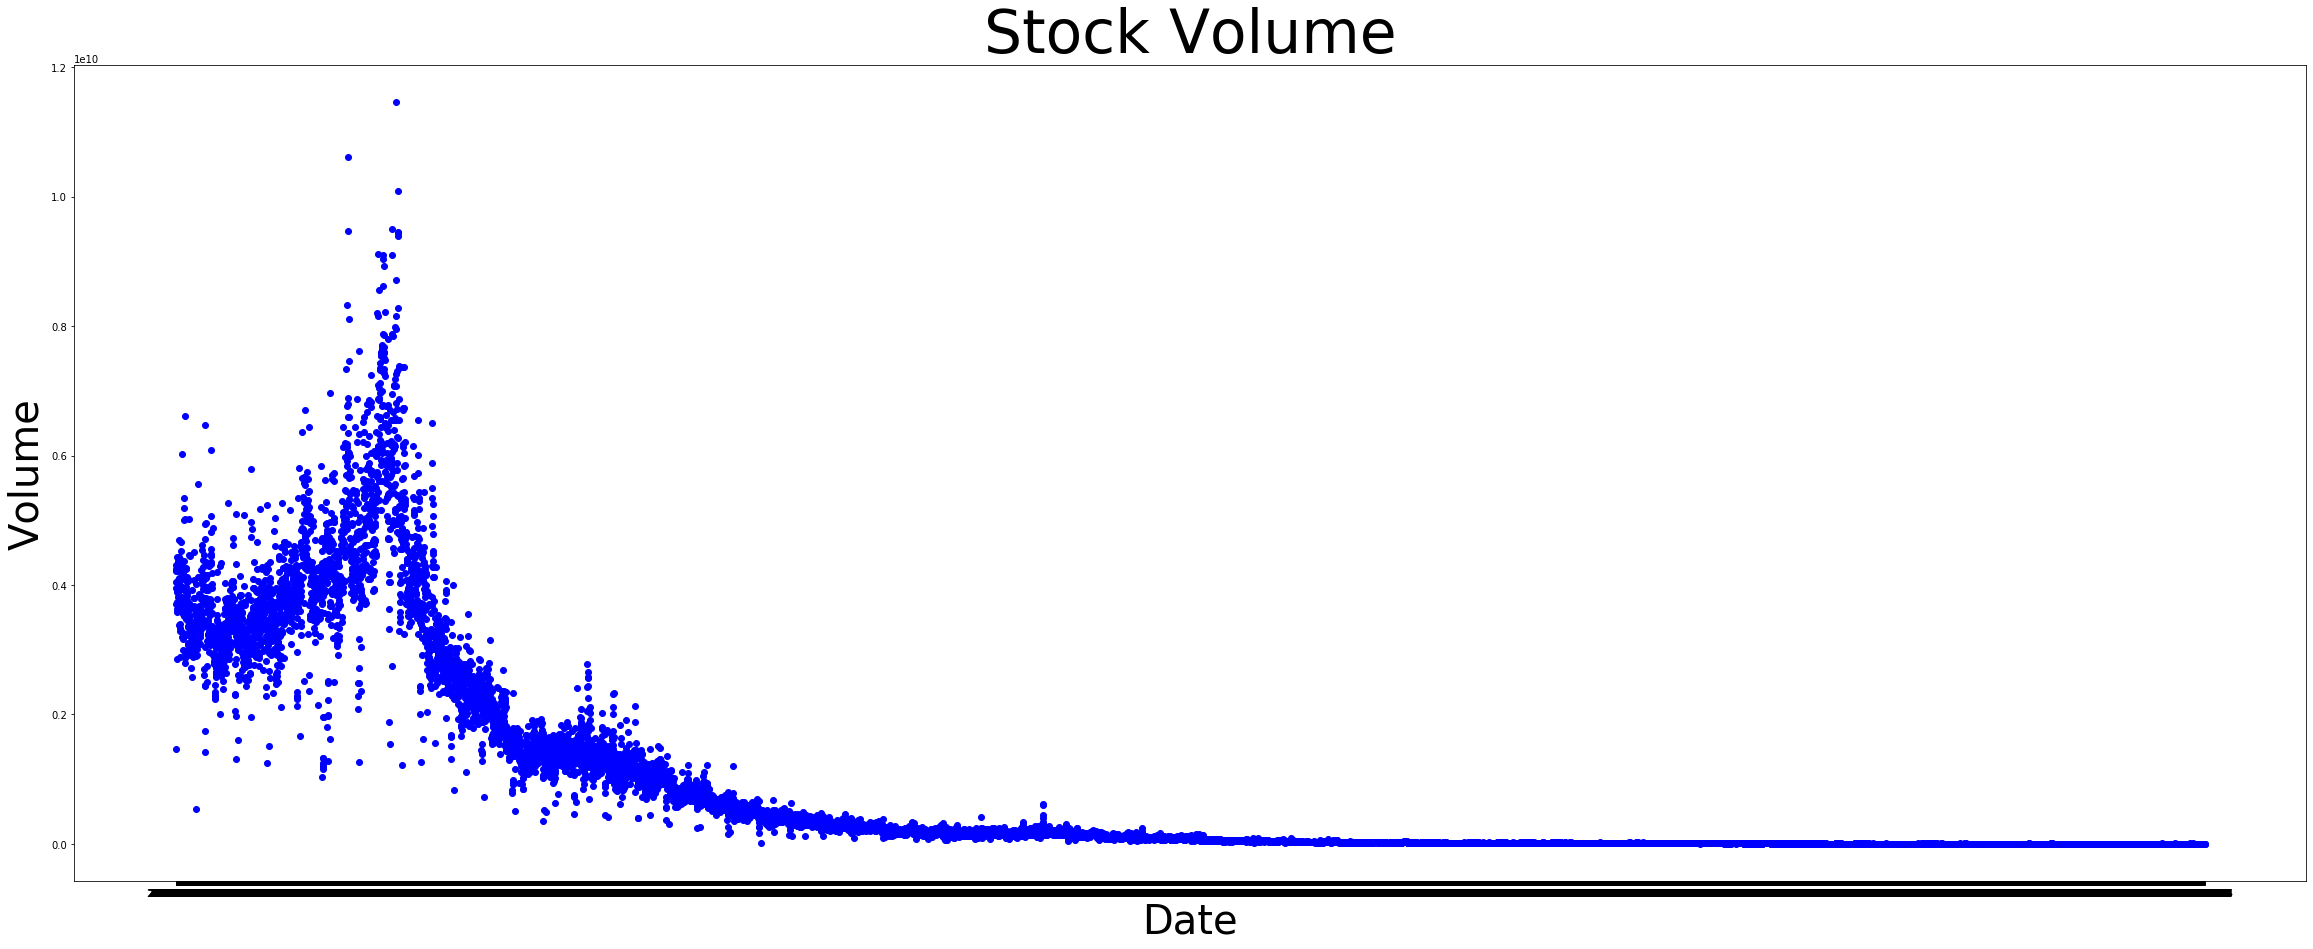

In [4]:
%matplotlib inline

plt.figure(figsize=(40,15))
plt.scatter(stocks['Date'], stocks['Volume'], c='b')
plt.title('Stock Volume', fontsize=60)
plt.xlabel('Date', fontsize=40)
plt.ylabel('Volume', fontsize=40)

## 2. Converting the Date Column

Next, we'll convert the Date column to a Pandas date type. This will allow us to do date comparisons with the column.

Once converted, we will perform comparisons generating a Boolean series that tells if each item in the Date column is after 2015-04-01. 
Then, we will sort the dataframe on the Date column. It's currently in descending order, but we'll want it to be in ascending order for some of the next steps:

In [5]:
stocks['Date'] = pd.to_datetime(stocks.Date)
stocks = stocks.sort_values('Date', ascending = True)
stocks.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


In [6]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16590 entries, 16589 to 0
Data columns (total 7 columns):
Date         16590 non-null datetime64[ns]
Open         16590 non-null float64
High         16590 non-null float64
Low          16590 non-null float64
Close        16590 non-null float64
Volume       16590 non-null float64
Adj Close    16590 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.0 MB


## 3. Generating Indicators for Time Series

Datasets taken from the stock market need to be handled as time series, which is different from datasets from some other sectors where we can treat each row as independent. Stock market data is sequential, and each observation comes a day after the previous observation. Thus, the observations are not all independent, and you can't treat them as such.

This means you have to be extra careful to not inject "future" knowledge into past rows when you do training and prediction. Injecting future knowledge will make our model fail in the real world. 

The time series nature of the data means that we can generate indicators to make our model more accurate. Here the indicators we will generate for each row:

- The average price from the past 5 days.
- The average price for the past 30 days.
- The average price for the past 365 days.
- The ratio between the average price for the past 5 days, and the average price for the past 365 days.
- The standard deviation of the price over the past 5 days.
- The standard deviation of the price over the past 365 days.
- The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.

Adding these comlumns will incorporate information from multiple prior rows into one, and will make predictions much more accurate:

In [7]:
#Calculate the mean for the past 5, 30, 365 days
stocks['day_5'] = stocks['Close'].rolling(5).mean().shift(1)
stocks['day_30'] = stocks['Close'].rolling(30).mean().shift(1)
stocks['day_365'] = stocks['Close'].rolling(365).mean().shift(1)

#Calculate the STD for the past 5, 365 days
stocks['std_5'] = stocks['Close'].rolling(5).std().shift(1)
stocks['std_365'] = stocks['Close'].rolling(365).std().shift(1)

#Calculate the mean volume for the past 5, 365 days
stocks['day_5_volume'] = stocks['Volume'].rolling(5).mean().shift(1)
stocks['day_365_volume'] = stocks['Volume'].rolling(365).mean().shift(1)

#Calculate the STD of the average volume over the past five days
stocks['5_volume_std'] = stocks['day_5_volume'].rolling(5).std().shift(1)

In [8]:
stocks.tail(10)

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365,std_5,std_365,day_5_volume,day_365_volume,5_volume_std
9,2015-11-23,2089.409912,2095.610107,2081.389893,2086.590088,3.587980e+09,2086.590088,2071.523974,2061.892989,2033.605890,18.246940,64.911334,3.930538e+09,3.523622e+09,6.821252e+07
8,2015-11-24,2084.419922,2094.120117,2070.290039,2089.139893,3.884930e+09,2089.139893,2078.204004,2064.197327,2034.018028,15.807754,64.768328,3.899886e+09,3.526334e+09,6.979154e+07
7,2015-11-25,2089.300049,2093.000000,2086.300049,2088.870117,2.852940e+09,2088.870117,2085.943994,2067.045658,2034.432712,3.491188,64.634873,3.791402e+09,3.528961e+09,7.278537e+07
6,2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,1.466840e+09,2090.110107,2087.002002,2070.199996,2034.835123,3.395982,64.514871,3.576712e+09,3.528637e+09,1.077890e+08
5,2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,4.245030e+09,2080.409912,2088.776025,2072.408333,2035.199864,1.309055,64.449800,3.144458e+09,3.524258e+09,1.652146e+08
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2073.984998,2035.531178,3.916109,64.370261,3.207544e+09,3.527800e+09,3.241733e+08
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2076.283993,2035.914082,7.956808,64.352527,3.232372e+09,3.526090e+09,3.390314e+08
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2077.908659,2036.234356,9.333599,64.277554,3.245514e+09,3.529468e+09,2.803620e+08
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343,19.599946,64.121622,3.536224e+09,3.532802e+09,1.696382e+08
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2080.771973,2080.237329,2036.869425,19.806136,64.058862,4.085838e+09,3.535838e+09,1.520693e+08


## 4. Splitting up the Data

Before we split the data between a train dataset and a test dataset, we have to make one final transformation. Since we're computing indicators that use historical data, there are some rows where there isn't enough historical data to generate them. Some of the indicators use 365 days of historical data, and the dataset starts on 1950-01-03. Thus, any rows that fall before 1951-01-03 don't have enough historical data to compute all the indicators. 

- We'll need to remove these rows before you split the data.
- We'll also use the dropna method to remove any rows with NaN values, passing in the axis=0 argument to drop rows.
- Finally, as mentioned, we will generate two new dataframes to use in making our algorithm. train should contain any rows in the data with a date less than 2013-01-01. test should contain any rows with a date greater than or equal to 2013-01-01.

In [9]:
#checking the data before the transformation
print(stocks.shape)

(16590, 15)


In [10]:
stocks.isnull().sum()

Date                0
Open                0
High                0
Low                 0
Close               0
Volume              0
Adj Close           0
day_5               5
day_30             30
day_365           365
std_5               5
std_365           365
day_5_volume        5
day_365_volume    365
5_volume_std       10
dtype: int64

In [11]:
#removing the initial year rows
stocks = stocks[stocks['Date'] > datetime(year=1951, month=1, day=2)]

In [12]:
#dropping rows with missing values
stocks = stocks.dropna(axis=0)

In [13]:
#checking the data after the transformation
print(stocks.shape)

(16225, 15)


In [14]:
stocks.isnull().sum()

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
Adj Close         0
day_5             0
day_30            0
day_365           0
std_5             0
std_365           0
day_5_volume      0
day_365_volume    0
5_volume_std      0
dtype: int64

In [15]:
train = stocks[stocks["Date"] < datetime(year=2013, month=1, day=1)]
test = stocks[stocks["Date"] >= datetime(year=2013, month=1, day=1)]

## 5. Making Predictions

This step will be divided in a few phases:

- Selecting an error metric.
- Initializing an instance of the LinearRegression class.
- Train a linear regression model.
- Making predictions.
- Compute the error between the predictions and the Close column of test.

For the fisrt phase, we will adopt the 9Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error), also called MAE, as an error metric, because it will show you how "close" you were to the price in intuitive terms. [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error), or MSE, is an alternative that is more commonly used, but makes it harder to intuitively tell how far off you are from the true price because it squares the error.

In [16]:
stocks.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'day_5',
       'day_30', 'day_365', 'std_5', 'std_365', 'day_5_volume',
       'day_365_volume', '5_volume_std'],
      dtype='object')

In [17]:
features = ['day_5', 'day_30', 'day_365', 'std_5', 'std_365', \
            'day_5_volume', 'day_365_volume', '5_volume_std']
y_train = train['Close']
y_test = test['Close']

# instantiate model
lr = LinearRegression()
# fit model
lr.fit(train[features], y_train)
# predict model
predictions = lr.predict(test[features])
# test model
mae = mean_absolute_error(test['Close'], predictions)
mae

16.116279607073384

In [18]:
lr.coef_

array([ 1.06110825e+00, -6.15009556e-02,  3.42684325e-04, -7.14528789e-02,
        1.50823736e-02, -9.59306179e-10,  1.08969159e-09, -4.80312636e-09])

In [19]:
lr.intercept_

0.12499606944516017

C:\Users\marce\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


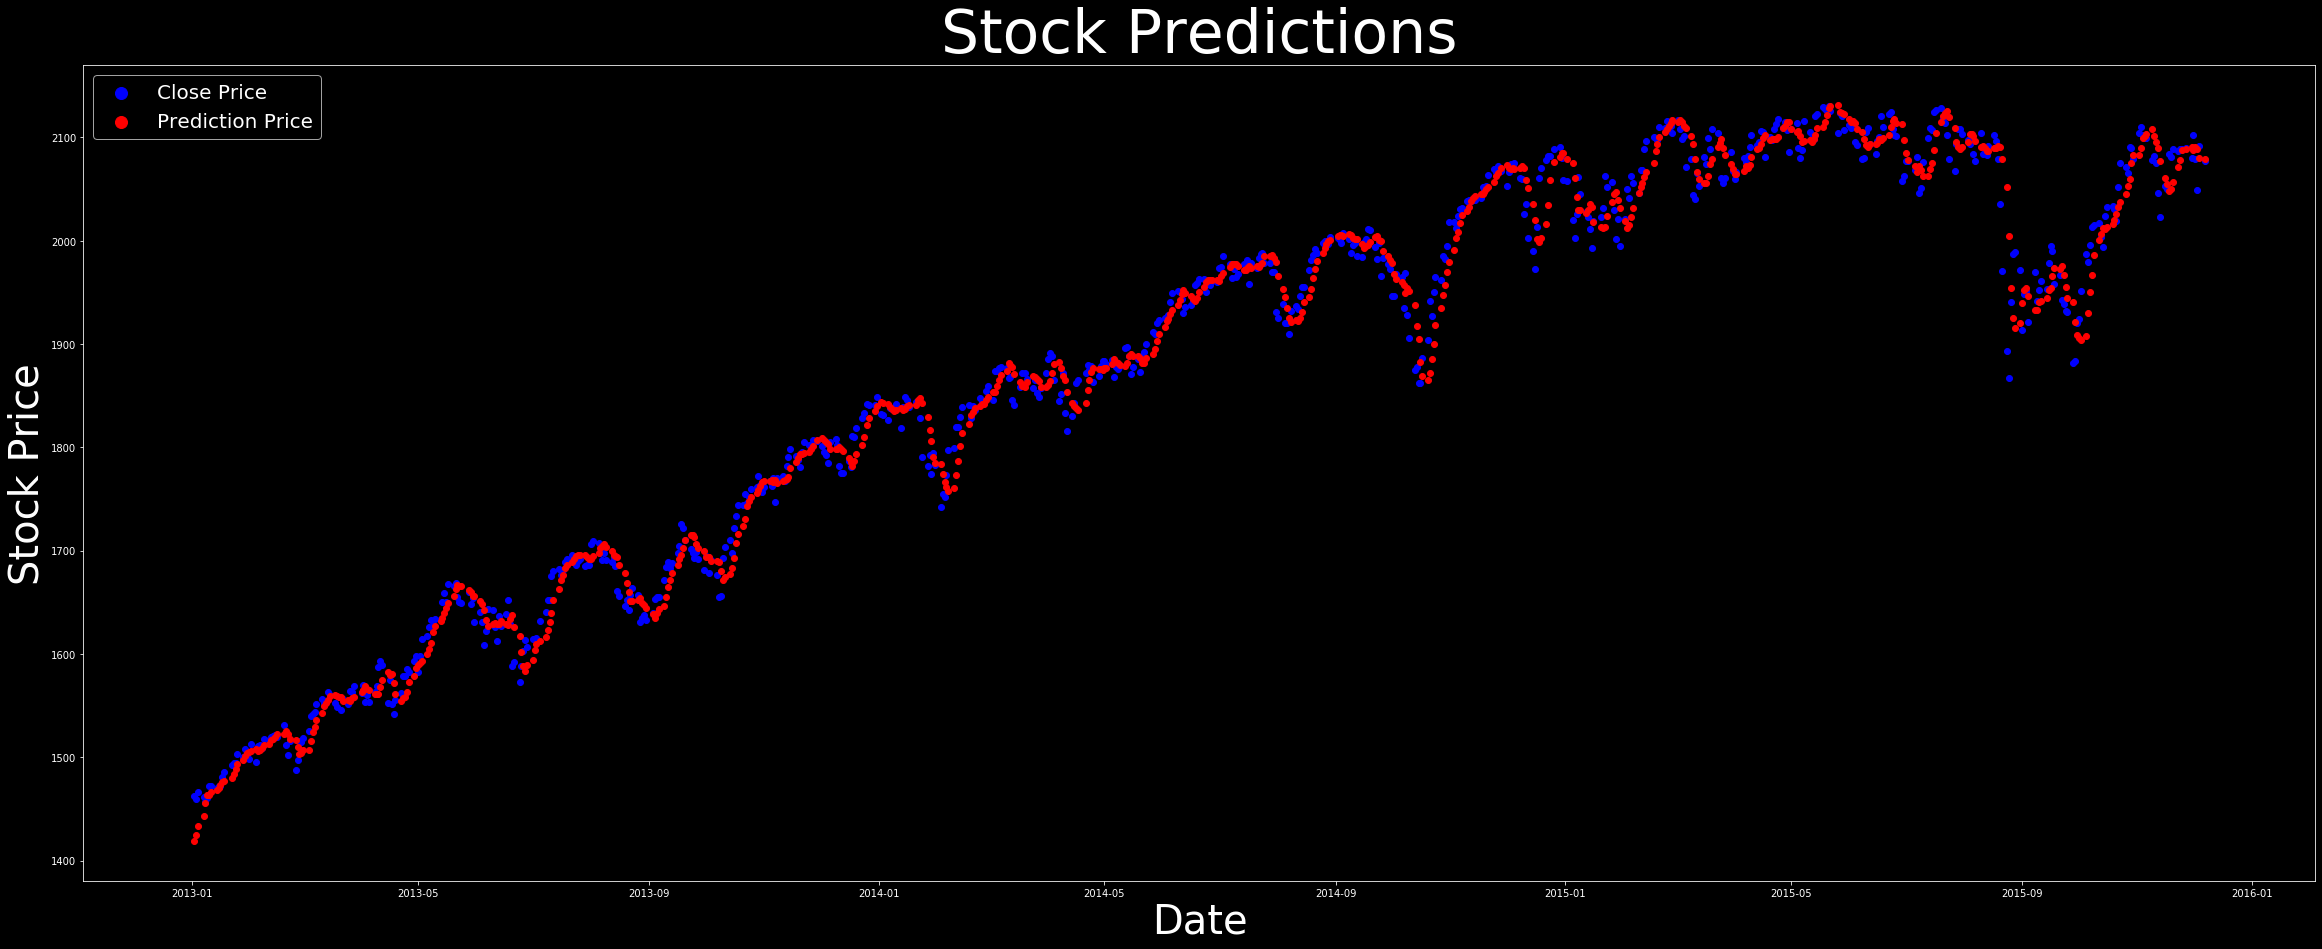

In [20]:
plt.style.use('dark_background')
# fandango_2015.Fandango_Stars.plot.kde(label = '2015', legend = True, figsize=(20,10))
# fandango_2016.fandango.plot.kde(label = '2016', legend = True)
plt.figure(figsize=(40,15))
plt.scatter(test['Date'], test['Close'], c='b', label = 'Close Price')
plt.scatter(test['Date'], predictions, c='r', label = 'Prediction Price')
plt.title('Stock Predictions', fontsize=60)
plt.xlabel('Date', fontsize=40)
plt.ylabel('Stock Price', fontsize=40)
plt.legend(fontsize=20, markerscale=2)

## 6. Next Steps

There's a lot of improvement still to be made on the indicator side, and there may be better indicators that you could use for prediction. We can also make significant structural improvements to the algorithm, and pull in data from other sources. Some suggestions for next steps:


- Think about some indicators that might be helpful to compute:
        - The average volume over the past five days.
        - The average volume over the past year.
        - The ratio between the average volume for the past five days, and the average volume for the past year.
        - The standard deviation of the average volume over the past five days.
        - The standard deviation of the average volume over the past year.
        - The ratio between the standard deviation of the average volume for the past five days, and the standard deviation of the average volume for the -past year.
        - The year component of the date.
        - The ratio between the lowest price in the past year and the current price.
        - The ratio between the highest price in the past year and the current price.
        - The month component of the date.
        - The day of week.
        - The day component of the date.
        - The number of holidays in the prior month.



- Accuracy would improve greatly by making predictions only one day ahead. For example, train a model using data from 1951-01-03 to 2013-01-02, make predictions for 2013-01-03, and then train another model using data from 1951-01-03 to 2013-01-03, make predictions for 2013-01-04, and so on. This more closely simulates what you'd do if you were trading using the algorithm.

- You can also improve the algorithm used significantly. Try other techniques, like a random forest, and see if they perform better.

- You can also incorporate outside data, such as the weather in New York City (where most trading happens) the day before, and the amount of Twitter activity around certain stocks.

- You can also make the system real-time by writing an automated script to download the latest data when the market closes, and make predictions for the next day.

- Finally, you can make the system "higher-resolution". You're currently making daily predictions, but you could make hourly, minute-by-minute, or second by second predictions. This will require obtaining more data, though. You could also make predictions for individual stocks instead of the S&P500.